In [1]:
!pip list

Package                                  Version               Editable project location
---------------------------------------- --------------------- -------------------------
absl-py                                  1.4.0
accelerate                               0.22.0
access                                   1.1.9
affine                                   2.4.0
aiobotocore                              2.5.4
aiofiles                                 22.1.0
aiohttp                                  3.8.4
aiohttp-cors                             0.7.0
aioitertools                             0.11.0
aiorwlock                                1.3.0
aiosignal                                1.3.1
aiosqlite                                0.19.0
albumentations                           1.3.1
alembic                                  1.12.0
altair                                   5.1.1
annotated-types                          0.5.0
annoy                                    1.17.3
ansiwrap         

In [2]:
import os
import cv2
import tensorflow as tf
import numpy as np
from typing import List
from matplotlib import pyplot as plt
import imageio

In [4]:
def load_video(path:str) -> List[float]:
    cap=cv2.VideoCapture(path)
    frames=[]
    for _ in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))):
        ret, frame = cap.read()
        frame=tf.image.rgb_to_grayscale(frame)
        frames.append(frame[190:236,80:220,:])
    cap.release()
    
    mean=tf.math.reduce_mean(frames)
    std=tf.math.reduce_std(tf.cast(frames,tf.float32))
    return tf.cast((frames-mean),tf.float32)/std

In [5]:
path="/kaggle/input/lipreading/data/s1/bbaf2n.mpg"
value=load_video(path)
value

<tf.Tensor: shape=(75, 46, 140, 1), dtype=float32, numpy=
array([[[[1.4991664 ],
         [1.4991664 ],
         [1.4616872 ],
         ...,
         [0.41227075],
         [0.41227075],
         [0.41227075]],

        [[1.4991664 ],
         [1.4991664 ],
         [1.4616872 ],
         ...,
         [0.41227075],
         [0.41227075],
         [0.41227075]],

        [[1.4616872 ],
         [1.4616872 ],
         [1.4991664 ],
         ...,
         [0.33731243],
         [0.33731243],
         [0.33731243]],

        ...,

        [[1.0494164 ],
         [1.0494164 ],
         [1.0119373 ],
         ...,
         [0.11243747],
         [0.11243747],
         [0.07495832]],

        [[1.0494164 ],
         [1.0494164 ],
         [1.0119373 ],
         ...,
         [0.11243747],
         [0.07495832],
         [0.07495832]],

        [[1.0494164 ],
         [1.0494164 ],
         [1.0119373 ],
         ...,
         [0.07495832],
         [0.07495832],
         [0.03747916]]],


  

In [6]:
#ADDITIONAL FUNCTION I MADE TO GET vocab WHICH IS A PARAMETER FOR THE CHAR_TO_NUM FUNCTION
def get_vocab():
    vocab=[]
    directory="/kaggle/input/lipreading/data/alignments/s1"
    for file in os.listdir(directory):
        file_path = os.path.join(directory, file)
        with open(file_path, 'r') as f:
            lines=f.readlines()
            for line in lines:
                line=line.split()
                vocab.append(line[2])
    return vocab       

In [8]:
vocab.append(' ')

In [7]:
vocab=get_vocab()

In [9]:
vocab=np.unique(vocab)

In [10]:
print(vocab)

[' ' 'a' 'again' 'at' 'b' 'bin' 'blue' 'by' 'c' 'd' 'e' 'eight' 'f' 'five'
 'four' 'g' 'green' 'h' 'i' 'in' 'j' 'k' 'l' 'lay' 'm' 'n' 'nine' 'now'
 'o' 'one' 'p' 'place' 'please' 'q' 'r' 'red' 's' 'set' 'seven' 'sil'
 'six' 'soon' 'sp' 't' 'three' 'two' 'u' 'v' 'white' 'with' 'x' 'y' 'z'
 'zero']


In [11]:
char_to_num= tf.keras.layers.StringLookup(vocabulary=vocab, oov_token="")
num_to_char=tf.keras.layers.StringLookup(vocabulary=char_to_num.get_vocabulary(), oov_token="",invert=True)

In [12]:
def load_alignments(path:str) -> List[str]:
    with open(path, 'r') as f:
        lines=f.readlines()
        
            
        
    tokens=[]
    for line in lines:
        line=line.split()
        if line[2]!= 'sil':
            tokens= [*tokens,' ',line[2]]
        
    return char_to_num(tf.reshape(tf.strings.unicode_split(tokens,input_encoding='UTF-8'),(-1)))[1:]

In [13]:
path="/kaggle/input/lipreading/data/alignments/s1/bbaf2n.align"
load_alignments(path)


<tf.Tensor: shape=(21,), dtype=int64, numpy=
array([ 5, 19, 26,  1,  5, 23, 47, 11,  1,  2, 44,  1, 13,  1, 44,  0, 29,
        1, 26, 29,  0])>

In [14]:
def load_data(path:str):
    path=bytes.decode(path.numpy())
    file_name=path.split('/')[-1].split('.')[0]
    video_path=os.path.join('/kaggle/input/lipreading/data','s1',f'{file_name}.mpg')
    alignment_path=os.path.join('/kaggle/input/lipreading/data','alignments','s1',f'{file_name}.align')
    frames=load_video(video_path)
    alignments=load_alignments(alignment_path)
    
    return frames,alignments

In [15]:
#TESTING THE OUTPUT FOR A SAMPLE FILE
path="/kaggle/input/lipreading/data/s1/bbaf2n.mpg"
frames, alignments=load_data(tf.convert_to_tensor(path))
print("frames:",frames)
print("alignments:",alignments)

frames: tf.Tensor(
[[[[1.4991664 ]
   [1.4991664 ]
   [1.4616872 ]
   ...
   [0.41227075]
   [0.41227075]
   [0.41227075]]

  [[1.4991664 ]
   [1.4991664 ]
   [1.4616872 ]
   ...
   [0.41227075]
   [0.41227075]
   [0.41227075]]

  [[1.4616872 ]
   [1.4616872 ]
   [1.4991664 ]
   ...
   [0.33731243]
   [0.33731243]
   [0.33731243]]

  ...

  [[1.0494164 ]
   [1.0494164 ]
   [1.0119373 ]
   ...
   [0.11243747]
   [0.11243747]
   [0.07495832]]

  [[1.0494164 ]
   [1.0494164 ]
   [1.0119373 ]
   ...
   [0.11243747]
   [0.07495832]
   [0.07495832]]

  [[1.0494164 ]
   [1.0494164 ]
   [1.0119373 ]
   ...
   [0.07495832]
   [0.07495832]
   [0.03747916]]]


 [[[1.424208  ]
   [1.424208  ]
   [1.424208  ]
   ...
   [0.33731243]
   [0.33731243]
   [0.33731243]]

  [[1.424208  ]
   [1.424208  ]
   [1.424208  ]
   ...
   [0.33731243]
   [0.33731243]
   [0.33731243]]

  [[1.424208  ]
   [1.424208  ]
   [1.424208  ]
   ...
   [0.29983327]
   [0.29983327]
   [0.29983327]]

  ...

  [[1.0494164 ]
   [

**VISUAL ANALYSIS**


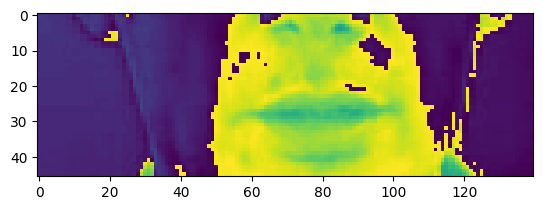

In [16]:
plt.imshow(frames[15])

**Splitting data into train and test and validation sets**

In [17]:
def mappable_function(path:str) ->List[str]:
    result = tf.py_function(load_data, [path], (tf.float32, tf.int64))
    return result

In [18]:
data = tf.data.Dataset.list_files('/kaggle/input/lipreading/data/s1/*.mpg')
data = data.shuffle(500,reshuffle_each_iteration=False)
data = data.map(mappable_function)
data = data.padded_batch(2, padded_shapes=([75,None,None,None],[40]))
data = data.prefetch(tf.data.AUTOTUNE)
# # ADDED DOR SPLIT
train = data.take(450)
test = data.skip(450)

In [19]:
frames, alighnments = data.as_numpy_iterator().next()

In [20]:
sample = data.as_numpy_iterator()

In [21]:
val = sample.next();val[0]

array([[[[[ 1.3824221 ],
          [ 1.3824221 ],
          [ 1.3824221 ],
          ...,
          [ 0.55296886],
          [ 9.992937  ],
          [ 9.281977  ]],

         [[ 1.3824221 ],
          [ 1.3824221 ],
          [ 1.3824221 ],
          ...,
          [ 0.        ],
          [ 9.5979595 ],
          [ 9.202981  ]],

         [[ 1.3034265 ],
          [ 1.3034265 ],
          [ 1.3034265 ],
          ...,
          [ 9.676954  ],
          [ 9.913941  ],
          [ 9.716453  ]],

         ...,

         [[ 0.868951  ],
          [ 0.868951  ],
          [ 0.868951  ],
          ...,
          [10.071933  ],
          [10.032434  ],
          [10.032434  ]],

         [[ 0.868951  ],
          [ 0.868951  ],
          [ 0.868951  ],
          ...,
          [10.032434  ],
          [10.032434  ],
          [10.032434  ]],

         [[ 0.9084488 ],
          [ 0.9084488 ],
          [ 0.868951  ],
          ...,
          [10.032434  ],
          [10.032434  ],
          

**MODEL BUILDING**

In [22]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, LSTM, Dense, Dropout, Bidirectional, MaxPool3D,Activation, Reshape, SpatialDropout3D, BatchNormalization, TimeDistributed, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, Callback

**Defining callbacks**

In [23]:
def scheduler(epoch,lr):
    if epoch < 30:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

In [ ]:
class SaveModelArchitecture(Callback):
    def __init__(self, save_path):
        super(SaveModelArchitecture, self).__init__()
        self.save_path = save_path

    def on_epoch_end(self, epoch, logs=None):
        if epoch % 5 == 0:  # Adjust the frequency of saving architecture as needed
            model_json = self.model.to_json()
            with open(os.path.join(self.save_path, f"model_architecture_epoch_{epoch}.json"), "w") as json_file:
                json_file.write(model_json)


In [26]:
class ProduceExample(tf.keras.callbacks.Callback):
    def __init__(self, dataset) -> None:
        self.dataset = dataset.as_numpy_iterator()
    def on_epoch_end(self, epoch, logs=None) -> None:
        data = self.dataset.next()
        yhat = self.model.predict(data[0])
        decoded = tf.keras.backend.ctc_decode(yhat, [75,75], greedy=False)[0][0].numpy()
        for x in range(len(yhat)):
            print('Original:', tf.strings.reduce_join(num_to_char(data[1][x])).numpy().decode('utf-8'))
            print('Prediction:', tf.strings.reduce_join(num_to_char(decoded[x])).numpy().decode('utf-8'))
            print('~'*100)

**Defining Loss function**

In [27]:
def CTCLoss(y_true,y_pred):
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1],dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1],dtype="int64")
    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

**Model building**

In [32]:

model = Sequential()
model.add(Conv3D(128, 3, input_shape=(75,46,140,1), padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(256, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(75, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(TimeDistributed(Flatten()))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Dense(char_to_num.vocabulary_size()+1, kernel_initializer='he_normal', activation='softmax'))


**TRAINING THE MODELS**

In [33]:
checkpoint_callback = ModelCheckpoint(os.path.join('models', 'checkpoint'), 
                                      monitor='loss', 
                                      save_weights_only=True,
                                      save_best_only=False)  # Save at the end of each epoch

schedule_callback = LearningRateScheduler(scheduler)
example_callback = ProduceExample(test)
save_architecture_callback = SaveModelArchitecture('models')

In [34]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss=CTCLoss)

In [35]:
model.fit(train, 
          validation_data=test, 
          epochs=100, 
          callbacks=[checkpoint_callback, schedule_callback, example_callback, save_architecture_callback])

Epoch 1/100
423/450 [===========================>..] - ETA: 18s - loss: 86.6054

[mpeg1video @ 0x7bb108f1f0c0] ac-tex damaged at 22 17
[mpeg1video @ 0x7bb108f1f0c0] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 85.8743

[mpeg1video @ 0x7bb1e009f300] ac-tex damaged at 22 17
[mpeg1video @ 0x7bb1e009f300] Warning MVs not available
[mpeg1video @ 0x7bacf81ff900] ac-tex damaged at 22 17
[mpeg1video @ 0x7bacf81ff900] Warning MVs not available


1/1 [==============================] - 2s 2s/step
Original: bin red ith g nine again
Prediction: le e e e n n
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: lay blue in q one soon
Prediction: le e e e n n
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 732s 2s/step - loss: 85.8743 - val_loss: 69.3337 - lr: 1.0000e-04
Epoch 2/100
176/450 [==========>...................] - ETA: 3:09 - loss: 72.5554

[mpeg1video @ 0x7bb1440bcd80] ac-tex damaged at 22 17
[mpeg1video @ 0x7bb1440bcd80] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 70.5841

[mpeg1video @ 0x7bb2a4054fc0] ac-tex damaged at 22 17
[mpeg1video @ 0x7bb2a4054fc0] Warning MVs not available


1/1 [==============================] - 0s 123ms/step
Original: set blue by h three soon
Prediction: la e e e e o
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: set hite ith p three soon
Prediction: la e e e e o
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 528s 1s/step - loss: 70.5841 - val_loss: 65.0997 - lr: 1.0000e-04
Epoch 3/100
178/450 [==========>...................] - ETA: 3:09 - loss: 67.6193

[mpeg1video @ 0x7bb108a3d080] ac-tex damaged at 22 17
[mpeg1video @ 0x7bb108a3d080] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 66.5424

[mpeg1video @ 0x7bb1c803d000] ac-tex damaged at 22 17
[mpeg1video @ 0x7bb1c803d000] Warning MVs not available


1/1 [==============================] - 0s 122ms/step
Original: place hite at x seven again
Prediction: la e e i e eo
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: bin hite by t nine again
Prediction: la e e i e en
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 532s 1s/step - loss: 66.5424 - val_loss: 61.8404 - lr: 1.0000e-04
Epoch 4/100
288/450 [==================>...........] - ETA: 1:52 - loss: 64.0805

[mpeg1video @ 0x7bad000b3040] ac-tex damaged at 22 17
[mpeg1video @ 0x7bad000b3040] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 63.6182

[mpeg1video @ 0x7bb13c0aa640] ac-tex damaged at 22 17
[mpeg1video @ 0x7bb13c0aa640] Warning MVs not available


1/1 [==============================] - 0s 117ms/step
Original: set blue by u zero no
Prediction: la e t e eon
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: set green at v four no
Prediction: la e t e eo
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 532s 1s/step - loss: 63.6182 - val_loss: 59.7769 - lr: 1.0000e-04
Epoch 5/100
267/450 [================>.............] - ETA: 2:08 - loss: 62.2958

[mpeg1video @ 0x7bb2b0010d80] ac-tex damaged at 22 17
[mpeg1video @ 0x7bb2b0010d80] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 61.7950

[mpeg1video @ 0x7bac6483ca00] ac-tex damaged at 22 17
[mpeg1video @ 0x7bac6483ca00] Warning MVs not available


1/1 [==============================] - 0s 115ms/step
Original: set red in n five soon
Prediction: la re t e on
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: set red ith v to please
Prediction: la re t e on
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 536s 1s/step - loss: 61.7950 - val_loss: 57.6907 - lr: 1.0000e-04
Epoch 6/100
450/450 [==============================] - ETA: 0s - loss: 60.3487

[mpeg1video @ 0x7bacf0433680] ac-tex damaged at 22 17
[mpeg1video @ 0x7bacf0433680] Warning MVs not available


1/1 [==============================] - 0s 121ms/step
Original: set green by c eight please
Prediction: la re t e ao
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: set red at h five soon
Prediction: la re t e ao
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 537s 1s/step - loss: 60.3487 - val_loss: 56.7167 - lr: 1.0000e-04
Epoch 7/100
234/450 [==============>...............] - ETA: 2:31 - loss: 58.8703

[mpeg1video @ 0x7bb1380250c0] ac-tex damaged at 22 17
[mpeg1video @ 0x7bb1380250c0] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 58.7255

[mpeg1video @ 0x7bb2b007a900] ac-tex damaged at 22 17
[mpeg1video @ 0x7bb2b007a900] Warning MVs not available


1/1 [==============================] - 0s 121ms/step
Original: place hite at j nine again
Prediction: la re t e on
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: lay red ith f zero no
Prediction: la re t e on
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 535s 1s/step - loss: 58.7255 - val_loss: 54.8863 - lr: 1.0000e-04
Epoch 8/100
436/450 [============================>.] - ETA: 9s - loss: 57.4438 

[mpeg1video @ 0x7baca16f32c0] ac-tex damaged at 22 17
[mpeg1video @ 0x7baca16f32c0] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 57.4337

[mpeg1video @ 0x7bb1c8006140] ac-tex damaged at 22 17
[mpeg1video @ 0x7bb1c8006140] Warning MVs not available


1/1 [==============================] - 0s 122ms/step
Original: place red at sp p six please
Prediction: la re t e on
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: place red in c to no
Prediction: la re i e o
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 538s 1s/step - loss: 57.4337 - val_loss: 52.4786 - lr: 1.0000e-04
Epoch 9/100
330/450 [=====================>........] - ETA: 1:24 - loss: 54.4272

[mpeg1video @ 0x7bad00113bc0] ac-tex damaged at 22 17
[mpeg1video @ 0x7bad00113bc0] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 53.9502

[mpeg1video @ 0x7bb108805440] ac-tex damaged at 22 17
[mpeg1video @ 0x7bb108805440] Warning MVs not available


1/1 [==============================] - 0s 125ms/step
Original: place hite by k one soon
Prediction: la re i e ao
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: set red ith o seven soon
Prediction: la re t e ao
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 538s 1s/step - loss: 53.9502 - val_loss: 50.0389 - lr: 1.0000e-04
Epoch 10/100
450/450 [==============================] - ETA: 0s - loss: 52.2129

[mpeg1video @ 0x7bad0c015c00] ac-tex damaged at 22 17
[mpeg1video @ 0x7bad0c015c00] Warning MVs not available


1/1 [==============================] - 0s 114ms/step
Original: place green ith e nine again
Prediction: la re t ie ao
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: lay green at l nine soon
Prediction: la re t ie ao
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 532s 1s/step - loss: 52.2129 - val_loss: 48.0198 - lr: 1.0000e-04
Epoch 11/100
345/450 [======================>.......] - ETA: 1:12 - loss: 51.2492

[mpeg1video @ 0x7bb1480cb640] ac-tex damaged at 22 17
[mpeg1video @ 0x7bb1480cb640] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 50.9906

[mpeg1video @ 0x5b2285fea100] ac-tex damaged at 22 17
[mpeg1video @ 0x5b2285fea100] Warning MVs not available


1/1 [==============================] - 0s 122ms/step
Original: place green ith z one again
Prediction: la re i ie aon
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: set red in a eight please
Prediction: la re i e aon
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 529s 1s/step - loss: 50.9906 - val_loss: 47.1589 - lr: 1.0000e-04
Epoch 12/100
369/450 [=======================>......] - ETA: 56s - loss: 49.5633

[mpeg1video @ 0x7bb108b4c600] ac-tex damaged at 22 17
[mpeg1video @ 0x7bb108b4c600] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 49.6798

[mpeg1video @ 0x7bb29c077300] ac-tex damaged at 22 17
[mpeg1video @ 0x7bb29c077300] Warning MVs not available


1/1 [==============================] - 0s 121ms/step
Original: set blue ith u six please
Prediction: la re t ie an
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: bin green in n one soon
Prediction: la re t ie ao
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 529s 1s/step - loss: 49.6798 - val_loss: 46.1354 - lr: 1.0000e-04
Epoch 13/100
 82/450 [====>.........................] - ETA: 4:15 - loss: 49.4257

[mpeg1video @ 0x7bad10062680] ac-tex damaged at 22 17
[mpeg1video @ 0x7bad10062680] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 47.9771

[mpeg1video @ 0x7bb1380d4800] ac-tex damaged at 22 17
[mpeg1video @ 0x7bb1380d4800] Warning MVs not available


1/1 [==============================] - 0s 114ms/step
Original: place green in d four no
Prediction: la re t oe on
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: lay green ith a one again
Prediction: la re t ie ao
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 529s 1s/step - loss: 47.9771 - val_loss: 44.4789 - lr: 1.0000e-04
Epoch 14/100
 45/450 [==>...........................] - ETA: 4:41 - loss: 46.7628

[mpeg1video @ 0x7bb2ac069d40] ac-tex damaged at 22 17
[mpeg1video @ 0x7bb2ac069d40] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 46.6806

[mpeg1video @ 0x7bac64fd5900] ac-tex damaged at 22 17
[mpeg1video @ 0x7bac64fd5900] Warning MVs not available


1/1 [==============================] - 0s 118ms/step
Original: lay hite sp by f three soon
Prediction: la re i ie aon
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: lay hite in y nine again
Prediction: la bre t ie lae
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 532s 1s/step - loss: 46.6806 - val_loss: 42.0929 - lr: 1.0000e-04
Epoch 15/100
181/450 [===========>..................] - ETA: 3:06 - loss: 45.1339

[mpeg1video @ 0x7bb2980d5780] ac-tex damaged at 22 17
[mpeg1video @ 0x7bb2980d5780] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 45.1906

[mpeg1video @ 0x7bad041e8c80] ac-tex damaged at 22 17
[mpeg1video @ 0x7bad041e8c80] Warning MVs not available


1/1 [==============================] - 0s 116ms/step
Original: place red at p five soon
Prediction: la re it ie aon
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: set green by j to please
Prediction: la gre it ie pae
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 529s 1s/step - loss: 45.1906 - val_loss: 40.0420 - lr: 1.0000e-04
Epoch 16/100
246/450 [===============>..............] - ETA: 2:21 - loss: 44.0729

[mpeg1video @ 0x7bb114043fc0] ac-tex damaged at 22 17
[mpeg1video @ 0x7bb114043fc0] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 43.6315

[mpeg1video @ 0x7bb2a8033900] ac-tex damaged at 22 17
[mpeg1video @ 0x7bb2a8033900] Warning MVs not available


1/1 [==============================] - 0s 115ms/step
Original: set blue ith h nine again
Prediction: la bre it ie ae
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: set hite in o three again
Prediction: la re it ie an
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 530s 1s/step - loss: 43.6315 - val_loss: 38.4507 - lr: 1.0000e-04
Epoch 17/100
450/450 [==============================] - ETA: 0s - loss: 41.8585

[mpeg1video @ 0x7bb14003d7c0] ac-tex damaged at 22 17
[mpeg1video @ 0x7bb14003d7c0] Warning MVs not available


1/1 [==============================] - 0s 116ms/step
Original: place hite ith e to please
Prediction: la re it e lase
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: lay green at m one again
Prediction: la re it ie lan
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 533s 1s/step - loss: 41.8585 - val_loss: 37.6869 - lr: 1.0000e-04
Epoch 18/100
 49/450 [==>...........................] - ETA: 4:39 - loss: 41.6899

[mpeg1video @ 0x7bad0402c3c0] ac-tex damaged at 22 17
[mpeg1video @ 0x7bad0402c3c0] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 40.2526

[mpeg1video @ 0x7bb1075731c0] ac-tex damaged at 22 17
[mpeg1video @ 0x7bb1075731c0] Warning MVs not available


1/1 [==============================] - 0s 115ms/step
Original: lay red by y eight no
Prediction: set re it oe ao
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: place green ith e six no
Prediction: sat gre it r no
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 532s 1s/step - loss: 40.2526 - val_loss: 35.3759 - lr: 1.0000e-04
Epoch 19/100
 12/450 [..............................] - ETA: 5:00 - loss: 38.9357

[mpeg1video @ 0x7bb2a402bfc0] ac-tex damaged at 22 17
[mpeg1video @ 0x7bb2a402bfc0] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 37.8646

[mpeg1video @ 0x7bb0f0018080] ac-tex damaged at 22 17
[mpeg1video @ 0x7bb0f0018080] Warning MVs not available


1/1 [==============================] - 0s 119ms/step
Original: set green by c nine again
Prediction: bin grie it eie ain
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: lay blue in d five again
Prediction: la bre it ie ain
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 529s 1s/step - loss: 37.8646 - val_loss: 31.9285 - lr: 1.0000e-04
Epoch 20/100
402/450 [=========================>....] - ETA: 33s - loss: 36.0436

[mpeg1video @ 0x7bb1e00a87c0] ac-tex damaged at 22 17
[mpeg1video @ 0x7bb1e00a87c0] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 36.1020

[mpeg1video @ 0x5b228629e440] ac-tex damaged at 22 17
[mpeg1video @ 0x5b228629e440] Warning MVs not available


1/1 [==============================] - 0s 114ms/step
Original: set green ith x five again
Prediction: sit gre it ie again
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: place green in x seven soon
Prediction: plac blue it se son
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 532s 1s/step - loss: 36.1020 - val_loss: 31.4264 - lr: 1.0000e-04
Epoch 21/100
450/450 [==============================] - ETA: 0s - loss: 34.1076

[mpeg1video @ 0x7bb1140d64c0] ac-tex damaged at 22 17
[mpeg1video @ 0x7bb1140d64c0] Warning MVs not available
[mpeg1video @ 0x7bb294093580] ac-tex damaged at 22 17
[mpeg1video @ 0x7bb294093580] Warning MVs not available


1/1 [==============================] - 0s 114ms/step
Original: lay green ith m six no
Prediction: sat re it o no
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: bin hite ith h four please
Prediction: set re it or please
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 536s 1s/step - loss: 34.1076 - val_loss: 28.1655 - lr: 1.0000e-04
Epoch 22/100
246/450 [===============>..............] - ETA: 2:22 - loss: 31.9551

[mpeg1video @ 0x7bad0807c880] ac-tex damaged at 22 17
[mpeg1video @ 0x7bad0807c880] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 31.7893

[mpeg1video @ 0x7bb138068bc0] ac-tex damaged at 22 17
[mpeg1video @ 0x7bb138068bc0] Warning MVs not available


1/1 [==============================] - 0s 115ms/step
Original: lay blue by y five again
Prediction: la blue by ene again
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: place green at q nine again
Prediction: place gre an ine again
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 533s 1s/step - loss: 31.7893 - val_loss: 26.5508 - lr: 1.0000e-04
Epoch 23/100
234/450 [==============>...............] - ETA: 2:30 - loss: 29.9291

[mpeg1video @ 0x7bacf0459740] ac-tex damaged at 22 17
[mpeg1video @ 0x7bacf0459740] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 29.9830

[mpeg1video @ 0x7bb108a42a40] ac-tex damaged at 22 17
[mpeg1video @ 0x7bb108a42a40] Warning MVs not available


1/1 [==============================] - 0s 116ms/step
Original: set red ith i four please
Prediction: sen red it for please
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: place green ith l one soon
Prediction: place gre it oe son
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 533s 1s/step - loss: 29.9830 - val_loss: 25.3861 - lr: 1.0000e-04
Epoch 24/100
 16/450 [>.............................] - ETA: 5:03 - loss: 29.0812

[mpeg1video @ 0x7bb29402c0c0] ac-tex damaged at 22 17
[mpeg1video @ 0x7bb29402c0c0] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 27.8506

[mpeg1video @ 0x7bad080a1c40] ac-tex damaged at 22 17
[mpeg1video @ 0x7bad080a1c40] Warning MVs not available


1/1 [==============================] - 0s 115ms/step
Original: set hite in b five again
Prediction: set hite in nine again
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: lay hite ith f six no
Prediction: sit hite it for no
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 532s 1s/step - loss: 27.8506 - val_loss: 22.1194 - lr: 1.0000e-04
Epoch 25/100
 92/450 [=====>........................] - ETA: 4:08 - loss: 26.1166

[mpeg1video @ 0x7bb14400c680] ac-tex damaged at 22 17
[mpeg1video @ 0x7bb14400c680] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 25.7611

[mpeg1video @ 0x7bb2ac1e3900] ac-tex damaged at 22 17
[mpeg1video @ 0x7bb2ac1e3900] Warning MVs not available


1/1 [==============================] - 0s 116ms/step
Original: set blue in n one again
Prediction: bet blue in ne again
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: lay blue ith y seven soon
Prediction: bit blue it e son
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 531s 1s/step - loss: 25.7611 - val_loss: 20.3145 - lr: 1.0000e-04
Epoch 26/100
121/450 [=======>......................] - ETA: 3:50 - loss: 23.7127

[mpeg1video @ 0x7baca2125940] ac-tex damaged at 22 17
[mpeg1video @ 0x7baca2125940] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 23.9026

[mpeg1video @ 0x7bb1e0063a00] ac-tex damaged at 22 17
[mpeg1video @ 0x7bb1e0063a00] Warning MVs not available


1/1 [==============================] - 0s 115ms/step
Original: place red at p four no
Prediction: place re bt for no
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: place blue at i four no
Prediction: place blue at for no
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 536s 1s/step - loss: 23.9026 - val_loss: 17.6942 - lr: 1.0000e-04
Epoch 27/100
450/450 [==============================] - ETA: 0s - loss: 22.0211

[mpeg1video @ 0x7bb10c1ec540] ac-tex damaged at 22 17
[mpeg1video @ 0x7bb10c1ec540] Warning MVs not available


1/1 [==============================] - 0s 115ms/step
Original: set green by p six please
Prediction: set gre by six please
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: bin hite at g four no
Prediction: liy hite at for no
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 533s 1s/step - loss: 22.0211 - val_loss: 17.4006 - lr: 1.0000e-04
Epoch 28/100
370/450 [=======================>......] - ETA: 55s - loss: 20.2222

[mpeg1video @ 0x7bb2ac0c7bc0] ac-tex damaged at 22 17
[mpeg1video @ 0x7bb2ac0c7bc0] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 20.2505

[mpeg1video @ 0x7bac6439cec0] ac-tex damaged at 22 17
[mpeg1video @ 0x7bac6439cec0] Warning MVs not available


1/1 [==============================] - 0s 116ms/step
Original: set green at p zero no
Prediction: set gren it or no
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: set hite by i five soon
Prediction: set hite by five son
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 531s 1s/step - loss: 20.2505 - val_loss: 14.8343 - lr: 1.0000e-04
Epoch 29/100
 52/450 [==>...........................] - ETA: 4:35 - loss: 19.3923

[mpeg1video @ 0x7bb2980a5b00] ac-tex damaged at 22 17
[mpeg1video @ 0x7bb2980a5b00] Warning MVs not available


 53/450 [==>...........................] - ETA: 4:35 - loss: 19.4173

KeyboardInterrupt: 

LOADING THE MODEL AND MAKING PREDICTIONS

In [36]:
test_data=test.as_numpy_iterator()

In [38]:
sample=test_data.next()

In [39]:
yhat=model.predict(sample[0])

1/1 [==============================] - 0s 121ms/step


In [40]:
print('~'*100,'REAL TEXT')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in [sample[1]]]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ REAL TEXT


[<tf.Tensor: shape=(), dtype=string, numpy=b'bin green at u one againplace green ith l zero no'>]

In [41]:
decoded=tf.keras.backend.ctc_decode(yhat,input_length=[75,75],greedy=True)[0][0].numpy()

In [42]:
print('~'*100, 'PREDICTIONS')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ PREDICTIONS


[<tf.Tensor: shape=(), dtype=string, numpy=b'bin ren it ne again'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'place green ith fo no'>]

In [43]:
sample=load_data(tf.convert_to_tensor('/kaggle/input/lipreading/data/s1/bbaf5a.mpg'))


In [44]:
print('~'*100,'REAL TEXT')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in [sample[1]]]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ REAL TEXT


[<tf.Tensor: shape=(), dtype=string, numpy=b'bin blue at f five again'>]

In [45]:
yhat=model.predict(tf.expand_dims(sample[0],axis=0))

1/1 [==============================] - 1s 519ms/step


In [46]:
decoded=tf.keras.backend.ctc_decode(yhat,input_length=[75],greedy=True)[0][0].numpy()

In [47]:
print('~'*100,'PREDICTIONS')
prediction=[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]
print(prediction)

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ PREDICTIONS
[<tf.Tensor: shape=(), dtype=string, numpy=b'bin blue at five ain'>]
